## Gestão de ambientes multicloud

#### Esse sistema envolve um Pipeline de Dados das clouds Azure e AWS e a predição de custos por meio de Random Forest. Foram realizadas duas abordagens: uma análise individual, aplicando o modelo separadamente para cada cloud, e uma análise conjunta, que combinou os dados de CPU e memória de ambas as plataformas para estimar os custos de forma integrada.

---

#### Importação das bibliotecas importantes para o sistema

In [1]:
import requests  # Requisições HTTP (ex: APIs)
import pandas as pd  # Manipulação de dados
from sklearn.ensemble import RandomForestRegressor  # Para o processo de regressão usando Random Forest
from sklearn.metrics import root_mean_squared_error, r2_score  # Métricas de avaliação
from sklearn.model_selection import train_test_split  # Para dividir os dados entre treino e teste
import numpy as np  # Operações numéricas
import json  # Para anipulação de arquivos JSON
 # Para visualização grafica
import matplotlib.pyplot as plt  
import seaborn as sns 
import shap  # Para o processo de interpretabilidade do modelo ML usando a técnica SHAP
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder # usada para codificação de variáveis categórica
from sklearn.model_selection import GridSearchCV

#### Ingestão dos dados de AWS Princing
Este trecho de código coleta e processa preços de instâncias EC2 (Linux, com locação compartilhada) diretamente da API pública de preços da AWS. Após filtrar os dados relevantes, ele os organiza em um DataFrame pandas contendo informações como tipo de instância, vCPUs, memória, região e preço por hora.

- **`cloud`**: Nome da nuvem (fixo: `"AWS"`, usado para possivel gestão);
- **`sku`**: Identificador único da oferta;
- **`instanceType`**: Tipo da instância (ex: `t2.micro`).
- **`vcpu`**: Número de CPUs virtuais;
- **`memory`**: Memória RAM da instância;
- **`region`**: Região onde a instância está disponível;
- **`price`**: Preço por unidade (h);
- **`unit`**: Unidade de cobrança (usado para ver se os dados estão vindo em preço/hora).


In [ ]:
import requests
import pandas as pd
import time

aws_url = "https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/AmazonEC2/current/index.json"
aws_precos = []

max_retries = 3  # Máximo de tentativas em caso de erro
timeout = 30     # Tempo máximo de espera para resposta (em segundos)
retries = 0
success = False

while not success and retries < max_retries:
    try:
        response = requests.get(
            aws_url,
            headers={"User-Agent": "Mozilla/5.0"},
            timeout=timeout
        )
        print(f"Status: {response.status_code} - URL: {aws_url}")

        if response.status_code != 200:
            print("Erro ao acessar a API da AWS.")
            print(response.text[:300])
            break

        aws_data = response.json()

        for sku, produto in aws_data["products"].items():
            if produto.get("productFamily") != "Compute Instance":
                continue

            atributos = produto.get("attributes", {})
            if atributos.get("operatingSystem") == "Linux" and atributos.get("tenancy") == "Shared":

                terms = aws_data["terms"]["OnDemand"].get(sku, {})
                for term_key, term_data in terms.items():
                    price_dimensions = term_data.get("priceDimensions", {})
                    for dimension_key, dimension in price_dimensions.items():
                        try:
                            preco = {
                                "cloud": "AWS",
                                "sku": sku,
                                "instanceType": atributos.get("instanceType"),
                                "vcpu": atributos.get("vcpu"),
                                "memory": atributos.get("memory"),
                                "region": atributos.get("location"),
                                "price": float(dimension["pricePerUnit"]["USD"]),
                                "unit": dimension.get("unit")
                            }
                            aws_precos.append(preco)
                        except (KeyError, TypeError, ValueError) as e:
                            print(f"Erro ao extrair preço: {e}")

        success = True
        time.sleep(1)

    except requests.exceptions.Timeout:
        retries += 1
        print(f"Timeout. Tentativa {retries}/{max_retries}")
        time.sleep(5)

    except requests.exceptions.RequestException as e:
        print(f"Erro na requisição: {e}")
        break

    except ValueError:
        print("Erro ao decodificar JSON:")
        print(response.text[:300])
        break

if not success and retries >= max_retries:
    print("Número máximo de tentativas alcançado. Encerrando processo.")

# Criação do DataFrame, se houver dados
if aws_precos:
    df_aws = pd.DataFrame(aws_precos)
else:
    print("Nenhum dado coletado da AWS.")


#### Ingestão dos dados de Azure pricing calculator
Este código obtém preços das máquinas virtuais da Azure via API pública, navegando por todas as páginas disponíveis. Depois, filtra os preços em dólares (USD) e organiza os dados em um DataFrame com colunas padronizadas para facilitar análises. Informações extraídas:

- **`instanceType`**: Tipo da máquina virtual (nome do produto).  
- **`sku`**: Código único da oferta.  
- **`region`**: Região da Azure onde a VM está disponível.  
- **`price`**: Preço unitário em dólares (USD).  
- **`unit`**: Unidade de medida do preço (ex: hora, GB).  
- **`cloud`**: Nome da nuvem (fixo: `"Azure"`).  


In [3]:
import requests
import pandas as pd
import time

azure_url = "https://prices.azure.com/api/retail/prices?$filter=serviceName%20eq%20'Virtual%20Machines'"
todos_precos = []
max_retries = 3  # Maximum number of retries for failed requests
timeout = 30  # Timeout for requests in seconds

while azure_url:
    retries = 0
    success = False
    
    while not success and retries < max_retries:
        try:
            # Add timeout to prevent hanging requests
            response = requests.get(
                azure_url, 
                headers={"User-Agent": "Mozilla/5.0"}, 
                timeout=timeout
            )
            #print(f"Status: {response.status_code} - URL: {azure_url}")
            
            if response.status_code != 200:
                print("Erro ao acessar a API.")
                print(response.text[:300])
                break

            data = response.json()
            
            if "Items" not in data:
                print("Resposta sem campo 'Items'")
                print(data)
                break

            todos_precos.extend(data["Items"])
            
            # Get next page link or None if we're done
            azure_url = data.get("NextPageLink")
           
            time.sleep(1)
            
            success = True
            
        except requests.exceptions.Timeout:
            retries += 1
            print(f"Tempo esgotado. Retentativa {retries}/{max_retries}")
            time.sleep(5)  
            
        except requests.exceptions.RequestException as e:
            print("Erro na requisição:", e)
            break
            
        except ValueError:
            print("Erro ao decodificar JSON:")
            print(response.text[:300])
            break
    
    # parar loop em caso de exaustão de tenntativas
    if not success and retries >= max_retries:
        print("Máximo de tentativas alcançadas.")
        break

# Criação do DataFrame (caso não tenha ocorrido erro antes)
if todos_precos:
    df_azure = pd.DataFrame(todos_precos)
    df_azure = df_azure[df_azure["currencyCode"] == "USD"]
    df_azure = df_azure[["productName", "skuName", "armRegionName", "retailPrice", "unitOfMeasure"]]
    df_azure = df_azure.rename(columns={
        "productName": "instanceType",
        "skuName": "sku",
        "armRegionName": "region",
        "retailPrice": "price",
        "unitOfMeasure": "unit"
    })
    df_azure["cloud"] = "Azure"
else:
    print("Nenhum dado coletado.")

In [360]:
df_azure['price'].count()

482376

In [7]:
#armazenamento dos dados em variáveis auxiliares das requisções para não ocorrer sobrescrita
df_aws_all = df_aws
df_azure_all = df_azure

    A seleção aleatória de 7.000 dados foi aplicada apenas à AWS para equilibrar o volume em relação à Azure, que já possui menos registros, principalmente após o merge da estrtégia adotada pare ter valores de 'vcpu' e 'memory' das intâncias requisitas do conjunto de dados da Azure. Isso evita viés nas análises comparativas, garantindo que os dois conjuntos tenham representatividade semelhante

In [312]:
data_aws = df_aws_all.sample(n=7000, random_state=42)

#### Pré-processamento
    O pré-processamento vai envolver o tratamento da  estrutura dos dos dados a serem análisados, assim como remoção de possíveis valores nulos e dados não necessários para análise. 

    O dódigo abaixo é uma estratégia adotada para pegar dados de specs (vcpu e memory) de um JSON, com base no valor de SKU de uma instância do conjunto de dados da Azure. O JSON contem a seguinte estrtura para cada campo do JSON:
```json
{
  "armSkuName": "[nome de SKU (tipo e série do recurso)]",
  "vcpu": "[número de CPUs virtuais disponíveis em uma VM com base no valor de SKU]",
  "memory": "[quantidade de memória RAM (GB) em uma VM com base no valor de SKU ]"
}
    Essa abordagem serve para buscar possíveis valores importantes para análise de custo de uma VM da Azure (não é possível requisitar diretamente, então é nessário buscar outras formas de obter dados de specs). Os dados de specs desses JSON foram extraídos dos sites onde estão publicados specs de VMs.

Link de acesso:
[Lista de tamanho de VMs](https://learn.microsoft.com/en-us/azure/virtual-machines/sizes/overview?tabs=breakdownseries%2Cgeneralsizelist%2Ccomputesizelist%2Cmemorysizelist%2Cstoragesizelist%2Cgpusizelist%2Cfpgasizelist%2Chpcsizelist#general-purpose)

In [32]:
# Carrega o JSON das specs 
with open("azure_specs.json", "r") as f:
    specs = json.load(f)

df_specs = pd.DataFrame(specs)

# Ajusta o nome da coluna para mergear com o dataframe de conjunto de dados da Azure
df_specs = df_specs.rename(columns={"armSkuName": "sku"})

# Merge: acrescenta vcpu e memory no df_azure, onde sku é igual ao que está apresentado no conjunto de dados da Azure
df_azure_merge = df_azure_all.merge(df_specs, how="left", on="sku")

# Veja o resultado
print(df_azure_merge.head())

                            instanceType                    sku  \
0           Virtual Machines Dav4 Series            D2a v4 Spot   
1  Virtual Machines Easv6 Series Windows              E4-2as v6   
2  Virtual Machines Easv6 Series Windows              E4-2as v6   
3  Virtual Machines Dasv4 Series Windows  D16as v4 Low Priority   
4  Virtual Machines Dasv4 Series Windows  D16as v4 Low Priority   

             region   price    unit  cloud  vcpu  memory  
0  indonesiacentral  0.0216  1 Hour  Azure   NaN     NaN  
1          uaenorth  0.4780  1 Hour  Azure   NaN     NaN  
2          uaenorth  0.2940  1 Hour  Azure   NaN     NaN  
3  switzerlandnorth  0.7340  1 Hour  Azure   NaN     NaN  
4  switzerlandnorth  0.2200  1 Hour  Azure   NaN     NaN  


In [33]:
df_azure_merge

,instanceType,sku,region,price,unit,cloud,vcpu,memory
0,Virtual Machines Dav4 Series,D2a v4 Spot,indonesiacentral,0.0216,1 Hour,Azure,NaN,NaN
1,Virtual Machines Easv6 Series Windows,E4-2as v6,uaenorth,0.4780,1 Hour,Azure,NaN,NaN
2,Virtual Machines Easv6 Series Windows,E4-2as v6,uaenorth,0.2940,1 Hour,Azure,NaN,NaN
3,Virtual Machines Dasv4 Series Windows,D16as v4 Low Priority,switzerlandnorth,0.7340,1 Hour,Azure,NaN,NaN
4,Virtual Machines Dasv4 Series Windows,D16as v4 Low Priority,switzerlandnorth,0.2200,1 Hour,Azure,NaN,NaN
...,...,...,...,...,...,...,...,...
482371,Virtual Machines Esv5 Series Windows,E2s v5,brazilsoutheast,0.3530,1 Hour,Azure,NaN,NaN
482372,Virtual Machines Esv5 Series Windows,E2s v5,brazilsoutheast,0.2610,1 Hour,Azure,NaN,NaN
482373,Virtual Machines NDsr H100 v5 Series,ND96isrH100v5 Low Priority,southafricanorth,33.7340,1 Hour,Azure,NaN,NaN
482374,Virtual Machines Fasv6 Series Windows,F1as v6,swedensouth,0.1410,1 Hour,Azure,NaN,NaN


In [313]:
df_azure_merge.dropna(inplace=True) 

In [314]:
data_azure = df_azure_merge

In [315]:
print(data_aws.isnull().sum())
print(data_azure.isnull().sum())

cloud           0
sku             0
instanceType    0
vcpu            0
memory          0
region          0
price           0
unit            0
dtype: int64
instanceType    0
sku             0
region          0
price           0
unit            0
cloud           0
vcpu            0
memory          0
dtype: int64


In [316]:
data_aws.dropna(inplace=True)  # ou df.fillna()ch
data_azure.dropna(inplace=True)  # ou df.fillna()
print(data_aws.isnull().sum())
print(data_azure.isnull().sum())

cloud           0
sku             0
instanceType    0
vcpu            0
memory          0
region          0
price           0
unit            0
dtype: int64
instanceType    0
sku             0
region          0
price           0
unit            0
cloud           0
vcpu            0
memory          0
dtype: int64


In [317]:
#remoção de colunas dispensáveis para análise 
data_aws = data_aws.drop(columns=['unit'])
data_azure = data_azure.drop(columns=['unit'])

In [318]:
print(display(data_aws))
print(display(data_azure))

,cloud,sku,instanceType,vcpu,memory,region,price
23261,AWS,K7F84HY8MP563GJY,c5ad.16xlarge,64,128 GiB,US East (N. Virginia),10.43200
108011,AWS,TMXCG3VWVV2DSMVH,i3en.12xlarge,48,384 GiB,Asia Pacific (Hong Kong),0.00000
15192,AWS,T4BA3WWY9UNCSB5Q,r6i.xlarge,4,32 GiB,Europe (Zurich),0.00000
17078,AWS,9DWNXA5MUMEYHC7N,r7i.12xlarge,48,384 GiB,Asia Pacific (Thailand),4.06704
71572,AWS,78XYAN2AGWG45DGE,m5d.2xlarge,8,32 GiB,Asia Pacific (Osaka),3.58400
...,...,...,...,...,...,...,...
70824,AWS,VJYGEEY9WWEVWPZ8,i3en.large,2,16 GiB,US West (N. California),0.00000
41913,AWS,JAWABMBCVNYEFNUR,u7i-6tb.112xlarge,448,6144 GiB,Asia Pacific (Seoul),129.50705
130818,AWS,34XFXSWR7Y9RJ6EM,d3en.4xlarge,16,64 GiB,US East (N. Virginia),2.10300
104201,AWS,K66X3AAUUA7XKK6A,c5.xlarge,4,8 GiB,AWS GovCloud (US-East),0.20400


None


,instanceType,sku,region,price,cloud,vcpu,memory
206,Virtual Machines Ev5 Series,Standard_E96_v5,northeurope,6.768,Azure,96.0,672.0
207,Virtual Machines Ev5 Series,Standard_E96_v5,northeurope,34387.000,Azure,96.0,672.0
208,Virtual Machines Ev5 Series,Standard_E96_v5,northeurope,65809.000,Azure,96.0,672.0
728,Virtual Machines Mbdsv3 Series,Standard_M48bds_v3,westeurope,5.710,Azure,48.0,384.0
729,Virtual Machines Mbdsv3 Series,Standard_M48bds_v3,westeurope,29518.000,Azure,48.0,384.0
...,...,...,...,...,...,...,...
482059,Virtual Machines Dv5 Series Windows,Standard_D96_v5,italynorth,9.792,Azure,96.0,384.0
482060,Virtual Machines Dv5 Series Windows,Standard_D96_v5,italynorth,5.376,Azure,96.0,384.0
482163,Virtual Machines Dv5 Series,Standard_D96_v5,japaneast,5.952,Azure,96.0,384.0
482164,Virtual Machines Dv5 Series,Standard_D96_v5,japaneast,30762.000,Azure,96.0,384.0


None


O histograma abaixo serve verificar a frequência dos valores de preço da AWS e Azure, para entender como essses estão distribuidos.
Os dados indicam que a AWS apresenta uma distribuição de preços mais concentrada na faixa de valores baixos, com poucas ocorrências de custos muito elevados. Por outro lado, a Azure demonstra uma dispersão de preços maior e uma amplitude mais ampla, incluindo alguns valores significativamente mais altos. Essa diferença pode sugerir que a Azure oferece serviços mais caros ou com maior grau de configurabilidade e escalabilidade

É possível notar que os valores de preço da azure têm valores muito altos, no entanto, os dados foram puxados como VM e analisados que todos possuem dados de dolar por minuto. Como o Random Forest lida com outliers, pode não ter tanto impacto essa diferença. Além disso, foi realizada a tranformação dos dados para ficar na mesma escala, no entanto, a performance dos dois modelos desceram drasticamente. Por isso, a forma original dos dados de preço foram mantidas.

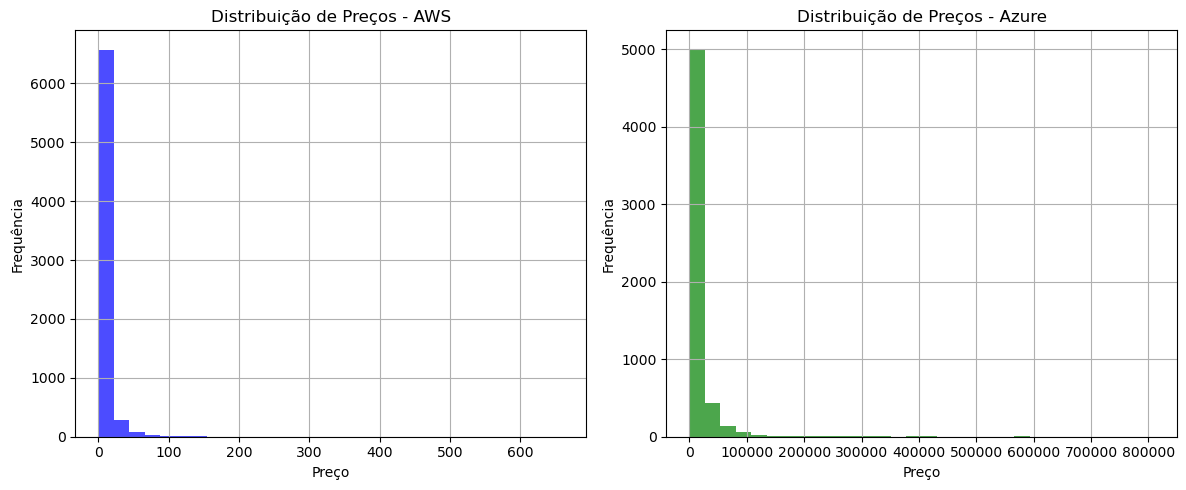

In [319]:
aws_prices = data_aws['price']
azure_prices = data_azure['price']

plt.figure(figsize=(12, 5))

#histograma AWS
plt.subplot(1, 2, 1)
plt.hist(aws_prices, bins=30, color='blue', alpha=0.7)
plt.title('Distribuição de Preços - AWS')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.grid(True)

#histograma Azure
plt.subplot(1, 2, 2)
plt.hist(azure_prices, bins=30, color='green', alpha=0.7)
plt.title('Distribuição de Preços - Azure')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Transformação dos dados
    O processo de transformação dos dados envolve uma estratégia com base no formato dos dados exigidos por um modelo de aprendizado de máquina, conjunto de dados númerico e não categórico. Neste problema será usado o Random Forest. Um ML supervisionado. O Random Forest é um modelo de aprendizado de máquina baseado em múltiplas árvores de decisão, usado para tarefas de classificação e regressão. Ele não requer normalização ou transformação dos dados, pois é baseado em divisões de nós (thresholds) e não depende de distâncias ou escala dos valores, o que o torna robusto a variáveis em diferentes escalas.

Técnicas de transformação, como `OneHotEncoder` e `get_dummies`, foram utilizadas e podem ser consideradas boas técnicas para análise de regiões e valores de instâncias importantes. No entanto, a aplicação dessas técnicas trouxe queda na performance observada no processo de avaliação. Portanto, a melhor abordagem foi a utilização da função `LabelEncoder`.

Função axuliar `enconde_categorical` para tranformar valores categóricos em núméricos de um dataframe.  

In [320]:
def encode_categorical_columns(df):
    """
    Aplica codificação numérica (Label Encoding) nas colunas categóricas de um DataFrame.

    Parâmetros:
    - df: DataFrame a ser processado.

    Retorno:
    - df_encoded: DataFrame com colunas categóricas codificadas como inteiros.
    """
    df_encoded = df.copy()
    categorical_cols = df_encoded.select_dtypes(include=['object']).columns

    le = LabelEncoder()
    for col in categorical_cols:
        df_encoded[col] = le.fit_transform(df_encoded[col])

    return df_encoded

##### Tratamento dos dados de Azure e AWS para análise individual dos dados.

In [321]:
#reordena as colunas para padronização de estrutura das colunas
data_aws = data_aws[["cloud", "sku", "instanceType", "vcpu", "memory", "region", "price"]]
data_azure = data_azure[["cloud", "sku", "instanceType", "vcpu", "memory", "region", "price"]]

In [323]:
#tratamento separados dos dados da azure para lidar com strings e transformar em dados numericos
#para o processo de análise por parte do modelo de aprendizado de máquina que será utilizado
data_aws["memory"] = data_aws["memory"].str.replace(" GiB", "").astype(float)

In [324]:
data_azure["vcpu"] = pd.to_numeric(data_azure["vcpu"], errors="coerce")
data_aws["vcpu"] = pd.to_numeric(data_aws["vcpu"], errors="coerce")

In [325]:
#remoção da coluna 'cloud' porque ela será armazenada no conjunto com os dois dados de AWS e Azure 
#para saber a origem dos dados quando for unido em "multicloud"
data_azure = encode_categorical_columns(data_azure.drop(columns=['cloud']))
data_aws = encode_categorical_columns(data_aws.drop(columns=['cloud']))

In [326]:
display(data_aws)
display(data_azure)

,sku,instanceType,vcpu,memory,region,price
23261,3898,33,64,128.0,69,10.43200
108011,5610,255,48,384.0,4,0.00000
15192,5485,611,4,32.0,39,0.00000
17078,1626,665,48,384.0,18,4.06704
71572,1139,353,8,32.0,12,3.58400
...,...,...,...,...,...,...
70824,6042,260,2,16.0,88,0.00000
41913,3702,732,448,6144.0,15,129.50705
130818,239,190,16,64.0,69,2.10300
104201,3887,23,4,8.0,0,0.20400


,sku,instanceType,vcpu,memory,region,price
206,17,2,96.0,672.0,33,6.768
207,17,2,96.0,672.0,33,34387.000
208,17,2,96.0,672.0,33,65809.000
728,24,4,48.0,384.0,53,5.710
729,24,4,48.0,384.0,53,29518.000
...,...,...,...,...,...,...
482059,7,1,96.0,384.0,22,9.792
482060,7,1,96.0,384.0,22,5.376
482163,7,0,96.0,384.0,23,5.952
482164,7,0,96.0,384.0,23,30762.000


In [363]:
data_aws.to_csv('dados_aws_tranformados.csv', index=False)
data_azure.to_csv('dados_azure_tranformados.csv', index=False)

##### Tratamento dos dados de Azure e AWS para análise conjunta dos dados.

In [329]:
# Junta os dois datasets
df_multicloud = pd.concat(
    [data_aws[['price', 'vcpu', 'memory']], data_azure[['price', 'vcpu', 'memory']]],
    axis=0,
    ignore_index=True
)

In [330]:
df_multicloud

,price,vcpu,memory
0,10.43200,64.0,128.0
1,0.00000,48.0,384.0
2,0.00000,4.0,32.0
3,4.06704,48.0,384.0
4,3.58400,8.0,32.0
...,...,...,...
12742,9.79200,96.0,384.0
12743,5.37600,96.0,384.0
12744,5.95200,96.0,384.0
12745,30762.00000,96.0,384.0


#### Separação e treinamento dos dados usando Random Forest
    O Treinamento vai estar envolvito tanto na análise individual quanto na análise geral

Função auxiliar `split_data` usada para separar os dados entre treino e teste. Possui parâmetros para uma lista de remoção, utilizada para excluir colunas do conjunto de características, a fim de facilitar o processo de eliminação de atributos que podem não ser necessários para o treinamento, e também um parâmetro para indicar a variável-alvo a ser coletada do DataFrame passado como argumento.

In [251]:
def split_data(df, list_remove, variable_name):
    """
    Separa os dados em variáveis independentes (X) e dependente (y), e divide em treino e teste.

    Parâmetros:
    - df: DataFrame contendo os dados completos
    - list_remove: lista de colunas que devem ser removidas de X (inclusive a variável alvo)
    - variable_name: string com o nome da variável a ser prevista (target)

    Retorna:
    - X: DataFrame com as variáveis independentes
    - y: Series com a variável dependente
    - X_train, X_test, y_train, y_test: conjuntos de treino e teste
    """
    X = df.drop(columns=list_remove)
    y = df[variable_name]
    return X, y, *train_test_split(X, y, test_size=0.2, random_state=42)

##### Separação e treino do modelo Random Forest com os dados de AWS e Azure
    Etapa utilizando os dados preparados de AWS e Azure para o processo de análise individual e identificação de padõres.

In [281]:
param_grid = {
    'n_estimators': [100, 2000, 1300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

In [206]:
def run_rf_gridsearch(X_train, y_train, param_grid, random_state=42, cv=5, scoring='r2'):
    """
    Executa GridSearchCV para RandomForestRegressor com dados de treino fornecidos.

    Args:
        X_train (array-like): Dados de entrada para treino.
        y_train (array-like): Rótulos/target para treino.
        param_grid (dict): Grade de parâmetros para o GridSearch.
        random_state (int): Semente para reprodução.
        cv (int): Número de folds para validação cruzada.
        scoring (str): Métrica para otimização.

    Returns:
        best_model: Melhor estimador encontrado.
        best_params (dict): Melhores hiperparâmetros encontrados.
    """

    rf = RandomForestRegressor(random_state=random_state)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, scoring=scoring, n_jobs=-1, verbose=2, error_score='raise')
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.best_params_

In [331]:
remove_list = ["price", "sku"]

X_aws, y_aws, X_train_aws, X_test_aws, y_train_aws, y_test_aws = split_data(data_aws, remove_list, 'price')

rf_aws, best_params = run_rf_gridsearch(X_train_aws, y_train_aws, param_grid, random_state=42, cv=5, scoring='r2')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [332]:
remove_list = [ "price", "sku"]

X_azure, y_azure, X_train_azure, X_test_azure, y_train_azure, y_test_azure = split_data(data_azure, remove_list, 'price')
rf_azure, best_params = run_rf_gridsearch(X_train_azure, y_train_azure, param_grid, random_state=42, cv=5, scoring='r2')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [333]:
remove_list = ["price"]
X_mult, y_mult, X_train_mult, X_test_mult, y_train_mult, y_test_mult = split_data(df_multicloud, remove_list, 'price')
rf_mult, best_params = run_rf_gridsearch(X_train_mult, y_train_mult, param_grid, random_state=42, cv=5, scoring='r2')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


#### Avaliação e análise das predições dos modelos treinados

sse processo envolve a análise individual e conjunta dos dados das clouds AWS e Azure.
Serão analisadas as respostas dos modelos quanto às métricas R² e RMSE, comumente usadas para avaliar modelos de regressão. Essas duas métricas se comportam da seguinte forma:

- R² (Coeficiente de Determinação):  Mede o quanto da variação da variável alvo é explicada pelo modelo. Seus valores geralmente variam de 0 a 1 (podendo ser negativo em alguns casos).  Um valor próximo de 1 indica que o modelo explica bem os dados. Exemplo: um R² de 0,8 significa que 80% da variação da variável dependente é explicada pelo modelo;
- RMSE (Root Mean Squared Error): É a raiz quadrada do erro quadrático médio. Mede a média das diferenças entre os valores previstos e os valores reais. Quanto menor o RMSE, melhor o desempenho do modelo.

Com uma resposta positiva quanto aos modelos avaliados, o processo de análise envolve o uso das abordagens de importância de características — por meio da função feature_importance, que identifica as principais variáveis segundo o modelo Random Forest — e do modelo de interpretabilidade SHAP.

Para consolidar os resultados obtidos e trazer maior confiabilidade e transparência, o SHAP é utilizado com o objetivo de verificar quais características são importantes para o processo de tomada de decisão do modelo, além de entender o comportamento das previsões com base nos valores das suas características.

A função auxiliar `evaluate_model` retorna as métricas R² e RMSE de um modelo de predição, com base nos seus valores de y predito e y real.
    

In [230]:
def evaluate_model(y_test, y_pred):
    """
    Calcula e imprime as métricas de avaliação do modelo.

    Parâmetros:
    - y_test: valores reais da variável alvo no conjunto de teste
    - y_pred: valores preditos pelo modelo para o conjunto de teste
    """
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    print("Random Forest R²:", r2)
    print("Random Forest RMSE:", rmse)
    return r2, rmse

A função auxiliar `plot_residuals_histogram` gera um histograma para visualizar a distribuição dos resíduos (diferença entre valores reais e preditos), ajudando a avaliar o desempenho e possíveis padrões de erro de um modelo de regressão.

In [343]:
def plot_residuals_histogram(y_true, y_pred, model_name="Modelo"):
    """
    Plota o histograma dos resíduos (diferença entre valores reais e preditos).

    Parâmetros:
    - y_true: valores reais
    - y_pred: valores preditos
    - model_name: nome do modelo (usado no título do gráfico)
    """
    residuos = y_true - y_pred

    plt.figure(figsize=(8, 6))
    sns.histplot(residuos, kde=True, bins=30, color='skyblue')
    plt.axvline(0, linestyle='--', color='red', label='Erro zero')
    plt.xlabel("Resíduo (Real - Predito)")
    plt.ylabel("Frequência")
    plt.title(f"Distribuição dos Resíduos - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


##### Avaliação das predições com os dados da AWS e Azure

###### Avaliação AWS

In [341]:
y_pred_aws = rf_aws.predict(X_test_aws)
r2_aws, rmse_aws = evaluate_model(y_test_aws, y_pred_aws)

Random Forest R²: 0.531139413358447
Random Forest RMSE: 15.704137177771692


###### Avaliação Azure

In [288]:
y_pred_azure = rf_azure.predict(X_test_azure)
r2, rmse = evaluate_model(y_test_azure, y_pred_azure)

Random Forest R²: 0.10373567748200896
Random Forest RMSE: 33398.58810833988


##### Avaliação das predições com os dados conjunto de AWS e Azure

In [176]:
y_pred_mult = rf_mult.predict(X_test_mult)

r2_mult, rmse_mult = evaluate_model(y_test_mult, y_pred_mult)

Random Forest R²: 0.28478378183245234
Random Forest RMSE: 172.53250298013768


Como o modelo usando os dados de AWS e Azure apresentou baixo desempenho, um gráfico de resíduo pode fornecer insights a respeito dos seus valores de predição e entender possíveis problemas.

O gráfico de resíduos mostra a distribuição dos erros do modelo em relação ao valor zero, indicado pela linha vermelha tracejada que representa o erro perfeito. Quando os resíduos se distribuem de forma simétrica ao redor de zero, isso sugere que os erros estão bem balanceados e o modelo não apresenta viés sistemático. Por outro lado, a presença de assimetria ou caudas longas no gráfico pode indicar a existência de viés no modelo ou a presença de outliers, apontando para possíveis problemas na capacidade preditiva do modelo.

O gráfico mostra uma concentração ainda maior de resíduos próximos de zero, com uma curva mais simétrica e estreita, indicando bom desempenho do modelo. Apesar disso, ainda existem outliers, especialmente positivos, sugerindo que em alguns casos o modelo subestimou os valores reais.

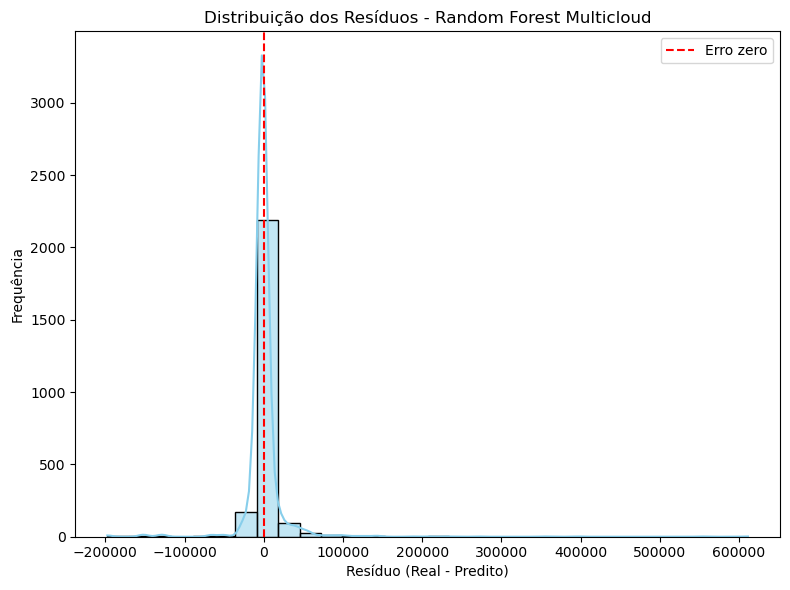

In [344]:
y_pred = rf_mult.predict(X_test_mult)
plot_residuals_histogram(y_test_mult, y_pred, model_name="Random Forest Multicloud")

##### Análise individual de AWS e Azure

A função auxiliar `plot_feature_importance` para plotar as principais caracateríticas por um modelo ML.

In [284]:
def plot_feature_importance(model, X, model_name, variable_name):
    """
    Plota a importância das características para um modelo Random Forest.

    Parâmetros:
    - model: modelo treinado (por exemplo, RandomForestRegressor)
    - X: DataFrame com as features usadas no treinamento
    - variable_name: string com o nome da variável predita
    """
    # Obtem os nomes das features
    features = X.columns
    # Obtem as importâncias
    importances = model.feature_importances_
    
    # Cria um DataFrame com ambos e ordena pela importância
    df_importance = pd.DataFrame({'feature': features, 'importance': importances})
    df_importance = df_importance.sort_values(by='importance', ascending=False).head(21)

    # Plotagem
    plt.figure(figsize=(6, 4))
    sns.barplot(x='importance', y='feature', data=df_importance)
    plt.xlabel('Importância das características')
    plt.ylabel('Características')
    plt.title(f'Importância das características - {model_name} ({variable_name})')
    plt.tight_layout()
    plt.show()

A função auxiliar `globalShap` para extrair explicações da biblioteca SHAP e plot de uma explicação global envolvendo uma variável-alvo.

O gráfico de explicação global para uma variável-alvo, tem no topo, as características mais influentes, indicando sua importância para a predição de um valor contínuo. No eixo $y$, estão listadas as características do conjunto de dados, enquanto no eixo $x$ são exibidos os intervalos dos valores SHAP para cada ponto do gráfico, cada um representando uma amostra dos dados. Os pontos com tonalidades azuladas correspondem a valores baixos da característica, ao passo que os tons avermelhados indicam valores altos. Pontos mais deslocados à esquerda do eixo $x$ indicam menor contribuição da característica para a predição. Em contraste, pontos posicionados mais à direita refletem maior influência da característica na predição da classe analisada. Esse tipo de análise, evidencia a distribuição e o impacto das características na predição de um valor de predição.

In [219]:
def globalShap(X, tree_model, nome_modelo, var_pred):
    """
    Gera um gráfico de explicação global usando valores SHAP para modelos baseados em árvores.

    Parâmetros:
        X (DataFrame ou array-like): Conjunto de dados (features) para explicação.
        tree_model (modelo treinado): Modelo baseado em árvores (ex: RandomForest, XGBoost, etc.).
        nome_modelo (str): Nome do modelo para título do gráfico.
        var_pred (str): Nome da variável predita (usada no título do gráfico).
    """

    # Cria o objeto TreeExplainer para o modelo fornecido
    explainer_shap_global = shap.TreeExplainer(tree_model)

    # Calcula os valores SHAP para todas as amostras em X
    shap_values_global = explainer_shap_global.shap_values(X)

    # Cria o gráfico resumo dos valores SHAP
    shap.summary_plot(
        shap_values_global,  # Valores SHAP calculados
        X,                   # Conjunto de dados original
        max_display=21,      # Número máximo de variáveis exibidas no gráfico
        plot_type="dot",     # Tipo de gráfico ("dot" é o padrão e mais usado)
        plot_size=(10, 4),   # Tamanho da figura
        show=False           # Não exibe imediatamente, para personalizar antes
    )

    #adiciona título ao gráfico
    plt.title(f'{nome_modelo} - Análise global: {var_pred}')

    #acessa o objeto da figura e dos eixos principais
    fig, ax = plt.gcf(), plt.gca()

    #personaliza o eixo x do gráfico principal
    ax.set_xlabel("Valor SHAP (impacto na saída do modelo)")

    #acessa a barra de cores (colorbar), que é o segundo eixo da figura
    cb_ax = fig.axes[1]

    #personaliza o rótulo da barra de cores
    cb_ax.set_ylabel("Valor da característica")

    #exibe o gráfico
    plt.show()
    return shap_values_global


###### Análise AWS

Os resultados abaixo evidenciam que o modelo Random Forest considerou valores de quantidade de CPUs, memória e tipo de instância como as características mais importantes para suas predições, conforme o critério de importância baseado na redução de impureza. Portanto, essas variáveis demonstram relevância na avaliação do custo de uma VM na AWS.

Adicionalmente, o gráfico de explicação gerado pelo SHAP mostra, por meio da contribuição atribuída a cada característica, sua influência no valor do preço. É possível notar  que quantidade de CPUs, memória e tipo de instância são as mais relevantes, conferindo consistência à análise. Além disso, quanto maiores os valores de CPUs e de memória, maior tende a ser o preço de uma VM. Como um tipo de instância resume múltiplas características técnicas da VM, o seu valor pode contribuir para o preço de uma VM, já que possui um formato que encapsula carcaterísticas técnicas de uma VM.

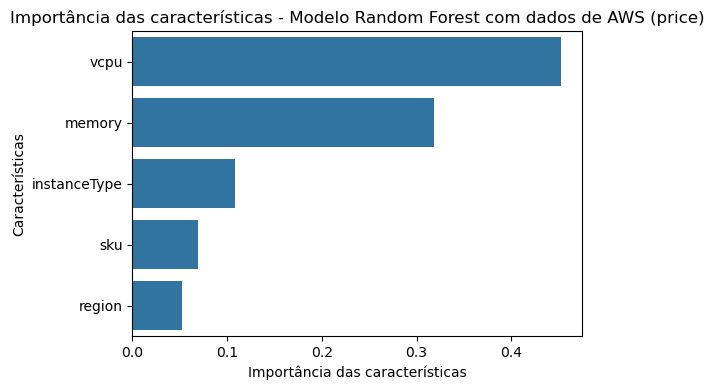

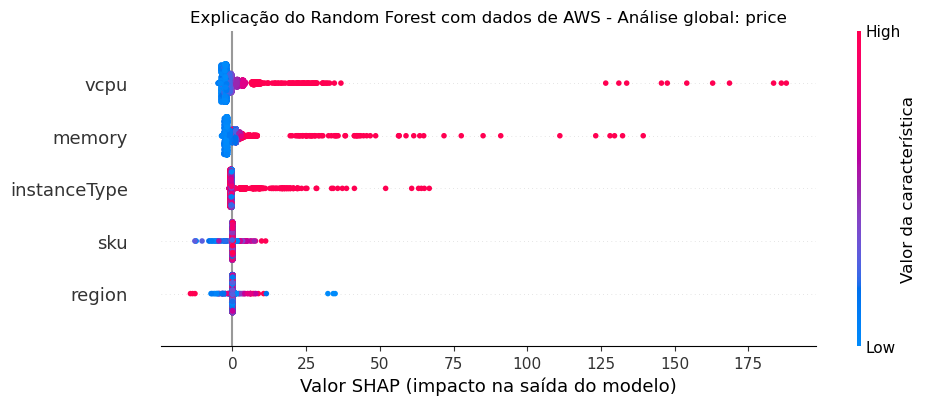

In [334]:
plot_feature_importance(rf_aws, X_train_aws, "Modelo Random Forest com dados de AWS", 'price')
global_shap_aws = globalShap(X_aws, rf_aws, "Explicação do Random Forest com dados de AWS", 'price')

###### Análise Azure

Na Azure, os resultados foram semelhantes aos da AWS, com o modelo Random Forest destacando vCPUs, memória e tipo de instância como variáveis mais importantes para prever o custo de uma VM. No entanto, o tipo de instância teve maior relevância na Azure, isso pode ter ocorrido porque a Azure concentra múltiplas características técnicas em um único identificador. A análise com SHAP confirmou essa influência, mostrando que valores mais altos de vCPUs e memória tendem a aumentar o preço, e que o tipo de instância contribui significativamente por refletir aspectos técnicos essenciais para prever o preço de uma VM da Azure.

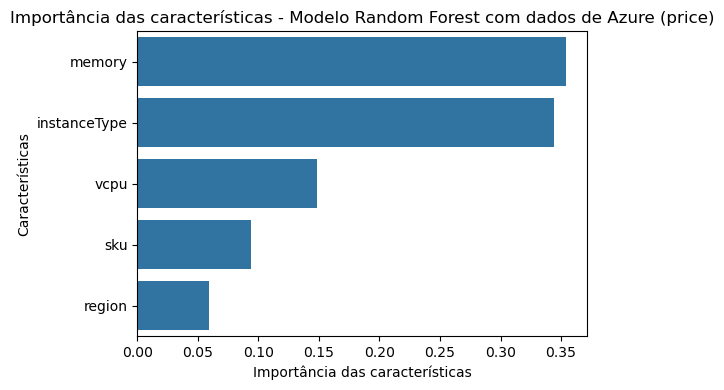

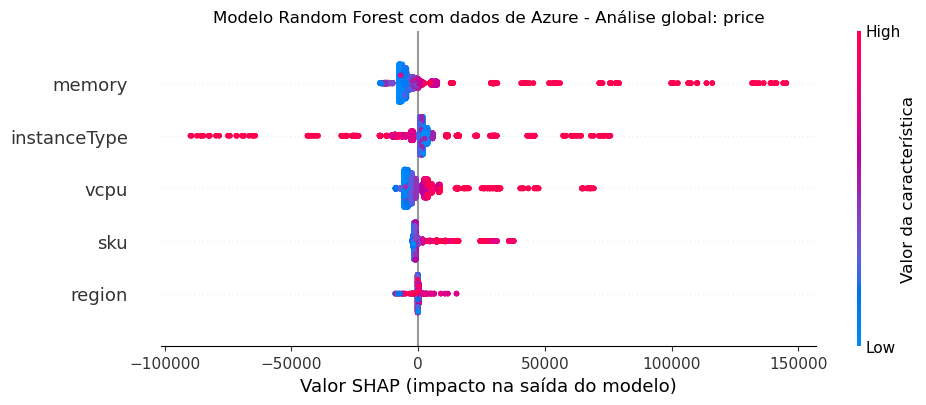

In [335]:
plot_feature_importance(rf_azure, X_train_azure, "Modelo Random Forest com dados de Azure", 'price')
global_shap_azure = globalShap(X_azure, rf_azure, 'Modelo Random Forest com dados de Azure', 'price')

Os valores de quantidade de CPUs e memória mostraram-se importantes em um modelo que considerou essas características combinadas para as duas clouds. No entanto, a baixa performance do modelo, refletida pelo baixo R², indica que essa união pode não capturar bem toda a variabilidade dos preços. Mesmo assim, a maior importância atribuída à memória sugere que, ao analisar características gerais para previsão de custos, ela pode ser um indicativo relevante a ser considerado.

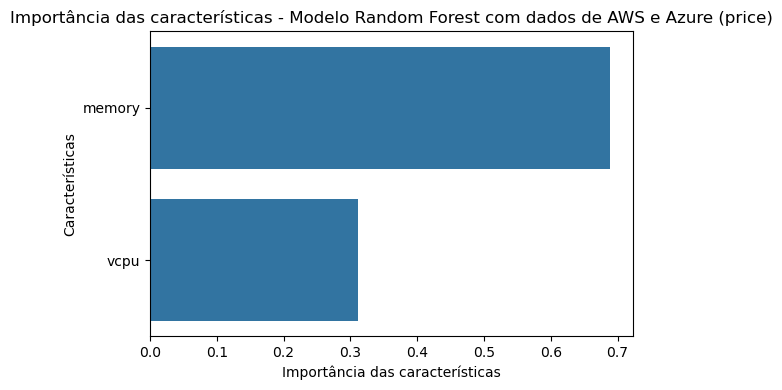

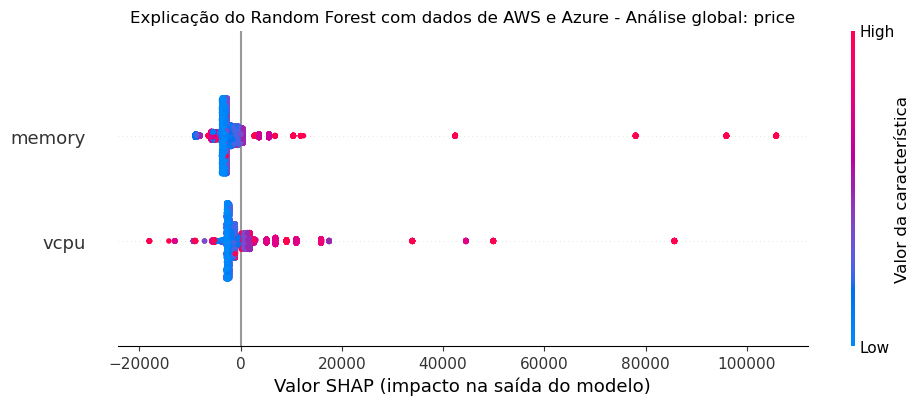

In [342]:
plot_feature_importance(rf_mult, X_mult, "Modelo Random Forest com dados de AWS e Azure",'price')
global_shap_multi = globalShap(X_mult, rf_mult, "Explicação do Random Forest com dados de AWS e Azure", 'price')